# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# Оглавление

1. Открытие данных
2. Предобработка данных
3. Подсчёт и добавление данных в таблицу
4. Исследовательский анализ данных    
    * Исследование площади, цены, числа комнат, высоты потолков
    * Исследование количества времени для продажи квартиры
    * Анализ редких и выбивающихся значений
    * Исследование факторов, влияющих на стоимость квартиры
    * Анализ десяти населённых пунктов с наибольшим числом объявлений
    * Анализ изменения цены по степени удалённости от центра
    * Сравнение выводов по квартирам в центре и общих выводов по всему городу
4. Общий вывод

# Открытие данных<a id="start"></a>

In [387]:
import pandas as pd
from pymystem3 import Mystem
from collections import Counter
import pymorphy2
from datetime import datetime
from scipy import stats
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах(м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

In [389]:
df = pd.read_csv('datasets/real_estate_data.csv', delimiter='\t')

In [390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [391]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [392]:
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


### Вывод

В нашем файле 22 колонки и 23699 строк. Данные четырёх типов, строчные (object), булевые (bool), натуральные числа (int64) и вещественные (float64). Последних больше всего (14 колонок), стоит посмотреть, во всех ли случаях это оправданно и возможно перевести в натуральный вид. Например, 'floors_total' с этажностью здания.
Излишним кажется отображать число балконов ('balcony') вещественным числом - оно должно быть натуральным.
Заметно, что данные неполные - например высота потолков ('ceiling_height') часто имеет нулевое значение.
Радует, что данные чисты в отношении отрицательных значений - их в колонках не наблюдается.
Значение колонки 'days_exposition' есть не во всех строчках - видимо, часть объявлений ещё актуальна.
Столбец 'is_apartment' имеет строчные значения из-за большого количества NaN.
Такие значения, как 'parks_around3000' и 'ponds_around3000' также некорректно представлены в виде вещественных чисел.
Также в столбце 'first_day_exposition' нужно изменить тип данных со строчного на временной, иначе с ним нельзя работать.

# Предобработка данных<a id="preprocessing"></a>

In [393]:
#проверим наличие None в таблице - таких значений не оказалось
df.isin(['None']).any()

total_images            False
last_price              False
total_area              False
first_day_exposition    False
rooms                   False
ceiling_height          False
floors_total            False
living_area             False
floor                   False
is_apartment            False
studio                  False
open_plan               False
kitchen_area            False
balcony                 False
locality_name           False
airports_nearest        False
cityCenters_nearest     False
parks_around3000        False
parks_nearest           False
ponds_around3000        False
ponds_nearest           False
days_exposition         False
dtype: bool

In [394]:
#посмотрим количество пропусков по столбцам
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

В большинстве колонок есть пропущенные значения. Посмотрим какую долю в каждой колонке составляют пропущенные значения - доля пропусков колеблется от 8% до 88%. 

In [395]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print(f'{col} - {round(pct_missing*100)}%')

total_images - 0.0%
last_price - 0.0%
total_area - 0.0%
first_day_exposition - 0.0%
rooms - 0.0%
ceiling_height - 39.0%
floors_total - 0.0%
living_area - 8.0%
floor - 0.0%
is_apartment - 88.0%
studio - 0.0%
open_plan - 0.0%
kitchen_area - 10.0%
balcony - 49.0%
locality_name - 0.0%
airports_nearest - 23.0%
cityCenters_nearest - 23.0%
parks_around3000 - 23.0%
parks_nearest - 66.0%
ponds_around3000 - 23.0%
ponds_nearest - 62.0%
days_exposition - 13.0%


Сначала заполним пропуски по ceiling_height, days_exposition, cityCenters_nearest, balcony, locality_name - они понадобятся для дальнейшего анализа.

Заполним пропуски в балконах - вероятно, что если эти значения в объявлениях не заполнены, их в квартире нет, поэтому заменим все NaN на 0. Также изменим тип значений с float на int.

In [396]:
df['balcony'] = df['balcony'].fillna(0).astype('int64')
df['balcony'][:5]

0    0
1    2
2    0
3    0
4    0
Name: balcony, dtype: int64

In [397]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

В высоте потолков заметен ряд выбросов от 20 до 35 метров, а также выброс в районе 100 метров.

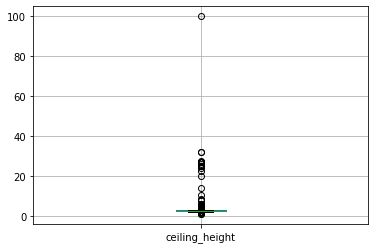

In [398]:
df.boxplot(column=['ceiling_height'])

Удалим выбросы - квартиры с высотой потолков меньше 2 и больше 5 метров. Таких оказалось 39 строчек.

In [399]:
df = df.query('(ceiling_height >= 2 and ceiling_height <= 5) or ceiling_height.isnull()')
df.ceiling_height = df.ceiling_height.fillna(df.ceiling_height.median())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23660 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23660 non-null  int64  
 1   last_price            23660 non-null  float64
 2   total_area            23660 non-null  float64
 3   first_day_exposition  23660 non-null  object 
 4   rooms                 23660 non-null  int64  
 5   ceiling_height        23660 non-null  float64
 6   floors_total          23574 non-null  float64
 7   living_area           21759 non-null  float64
 8   floor                 23660 non-null  int64  
 9   is_apartment          2762 non-null   object 
 10  studio                23660 non-null  bool   
 11  open_plan             23660 non-null  bool   
 12  kitchen_area          21391 non-null  float64
 13  balcony               23660 non-null  int64  
 14  locality_name         23611 non-null  object 
 15  airports_nearest   

В 49 строках отсутствует населенный пункт. Это совсем небольшой процент, можем соответсвующие строки удалить.

In [400]:
df = df.dropna(subset=['locality_name'])

Теперь поработаем со сроком размещения объявления. Есть гипотеза, что пропуски в этих значениях есть у ещё актуальных объявлениях. Проверим, насколько 'свежесть' объявлений с пропусками отличается от всего датасета.

In [401]:
#переведем данные в тип datetime
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [402]:
Counter(df['first_day_exposition'].dt.year)

Counter({2019: 2872,
         2018: 8499,
         2015: 1169,
         2017: 8171,
         2016: 2764,
         2014: 136})

In [403]:
Counter(df.query('days_exposition.isna()')['first_day_exposition'].dt.year)

Counter({2019: 1792, 2018: 956, 2017: 269, 2014: 18, 2016: 67, 2015: 70})

Заметно, что доля объявлений за 2019 год намного выше в выборке с пропусками. Можем заполнить пропуски в 'days_exposition' разницей между последней датой размещения объявления в датасете (вероятно, тогда и были выгружены данные) и датой размещения в строке с пропуском.

In [404]:
last_exposition_date = df['first_day_exposition'].max()

In [405]:
def actual_days_exposition(row):
    if pd.isna(row['days_exposition']):
        days_num = (last_exposition_date - row['first_day_exposition']).days
        return days_num
    return row['days_exposition']

In [406]:
df['days_exposition'] = df.apply(actual_days_exposition, axis=1).astype('int64')

In [407]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23611 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23611 non-null  int64         
 1   last_price            23611 non-null  float64       
 2   total_area            23611 non-null  float64       
 3   first_day_exposition  23611 non-null  datetime64[ns]
 4   rooms                 23611 non-null  int64         
 5   ceiling_height        23611 non-null  float64       
 6   floors_total          23526 non-null  float64       
 7   living_area           21715 non-null  float64       
 8   floor                 23611 non-null  int64         
 9   is_apartment          2747 non-null   object        
 10  studio                23611 non-null  bool          
 11  open_plan             23611 non-null  bool          
 12  kitchen_area          21351 non-null  float64       
 13  balcony         

Посмотрим значения переменных в столбце 'locality_name'. Похоже, часть из них имееются дубли, типа 'Мурино' и 'посёлок Мурино'.

In [408]:
df.locality_name.unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Создадим столбец 'toponim', в котором будут топонимы без типа населённого пункта - его мы уберём регулярным выражнием.

In [409]:
def toponim(row):
    return re.search(r'[А-ЯЁ].+', row).group()

In [410]:
df['toponim'] = df['locality_name'].apply(toponim)

In [411]:
df[['locality_name', 'toponim']]

,locality_name,toponim
0,Санкт-Петербург,Санкт-Петербург
1,посёлок Шушары,Шушары
2,Санкт-Петербург,Санкт-Петербург
3,Санкт-Петербург,Санкт-Петербург
4,Санкт-Петербург,Санкт-Петербург
...,...,...
23694,Санкт-Петербург,Санкт-Петербург
23695,Тосно,Тосно
23696,село Рождествено,Рождествено
23697,Санкт-Петербург,Санкт-Петербург


Заполним часть пропусков медианным значением по объявлениям по каждому топониму

In [412]:
for town in df['toponim'].unique():
    median = df.loc[df['toponim'] == town, 'cityCenters_nearest'].median()
    print(town, median)
    df.loc[(df['cityCenters_nearest'].isna()) & (df['toponim'] == town), 'cityCenters_nearest'] = median

Санкт-Петербург 12245.0
Шушары 24212.0
Янино-1 nan
Парголово 19311.0
Мурино 21888.0
Ломоносов 51677.0
Сертолово nan
Петергоф 33771.0
Пушкин 27930.5
Кудрово nan
Коммунар nan
Колпино 32018.0
Красный Бор

C:\Users\kryuk\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


 nan
Гатчина nan
Фёдоровское nan
Выборг nan
Кронштадт 49572.5
Кировск nan
Новое Девяткино nan
Металлострой 27602.0
Лебяжье nan
Сиверский nan
Молодцово nan
Кузьмоловский nan
Новая Ропша nan
Павловск 32683.0
Пикколово nan
Всеволожск nan
Волхов nan
Кингисепп nan
Приозерск nan
Сестрорецк 34821.0
Куттузи nan
Аннино nan
Ефимовский nan
Плодовое nan
Заклинье nan
Торковичи nan
Первомайское nan
Красное Село 29142.0
Понтонный 32354.0
Сясьстрой nan
Старая nan
Лесколово nan
Новый Свет nan
Сланцы nan
Путилово nan
Ивангород nan
Шлиссельбург nan
Никольское nan
Зеленогорск 53381.0
Сосновый Бор nan
Оржицы nan
Кальтино nan
Романовка nan
Бугры nan
Рощино nan
Кириши nan
Луга nan
Волосово nan
Отрадное nan
Павлово nan
Оредеж nan
Копорье nan
Молодёжное 65764.0
Тихвин nan
Победа nan
Нурма nan
Синявино nan
Тосно nan
Стрельна 23506.0
Бокситогорск nan
Александровская 27468.0
Лопухинка nan
Пикалёво nan
Терволово nan
Советский nan
Подпорожье nan
Петровское nan
Токсово nan
Сельцо nan
Вырица nan
Кипень nan
Келози nan

Выясним максимальное значение и заполним остальные пропуски маркерами, а также приведем значения к натуральному виду

In [413]:
df.cityCenters_nearest.max()

65968.0

In [414]:
df.cityCenters_nearest = df.cityCenters_nearest.fillna(99999).astype('int64')

Также приведем к вещественному виду 'floors_total', 'airports_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest' и заполним их пропуски маркером 99999 - это столбцы не очень важны для анализа

In [415]:
for column in ['floors_total', 'airports_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']:
    df[column] = df[column].fillna(99999).astype('int64')

Пропуски в жилой и кухонной площади заполним медианным соотношением жилой/кухонной площади к общей в зависимости от количества комнат в квартире. Оставшиеся пропуски заполним маркером

In [416]:
df['living_coef'] = df['living_area'] / df['total_area']

In [417]:
living_k = df.groupby('rooms')['living_coef'].median()

In [418]:
for room_num in living_k.index:
    df.loc[(df['living_area'].isnull()) & (df['rooms'] == room_num), 'living_area'] = df.loc[(df['living_area'].isnull()) & (df['rooms'] == room_num), 'total_area'] * living_k[room_num]

In [419]:
df['kitchen_coef'] = df['kitchen_area'] / df['total_area']
kitchen_k = df.groupby('rooms')['kitchen_coef'].median()
for room_num in kitchen_k.index:
    df.loc[(df['kitchen_area'].isna()) & (df['rooms'] == room_num), 'kitchen_area'] = df.loc[(df['kitchen_area'].isna()) & (df['rooms'] == room_num), 'total_area'] * kitchen_k[room_num]

In [420]:
#оставшиеся пропуски заполним маркером
df['kitchen_area'] = df['kitchen_area'].fillna(99999)

In [421]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            20864
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest            0
cityCenters_nearest         0
parks_around3000            0
parks_nearest               0
ponds_around3000            0
ponds_nearest               0
days_exposition             0
toponim                     0
living_coef              1896
kitchen_coef             2260
dtype: int64

Проверим данные на дубликаты - их не обнаружено.

In [422]:
df[df.duplicated()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,toponim,living_coef,kitchen_coef


In [423]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23611 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23611 non-null  int64         
 1   last_price            23611 non-null  float64       
 2   total_area            23611 non-null  float64       
 3   first_day_exposition  23611 non-null  datetime64[ns]
 4   rooms                 23611 non-null  int64         
 5   ceiling_height        23611 non-null  float64       
 6   floors_total          23611 non-null  int64         
 7   living_area           23611 non-null  float64       
 8   floor                 23611 non-null  int64         
 9   is_apartment          2747 non-null   object        
 10  studio                23611 non-null  bool          
 11  open_plan             23611 non-null  bool          
 12  kitchen_area          23611 non-null  float64       
 13  balcony         

## Вывод

В датасет оказалось достаточно много пропусков в большинстве столбцов - от 8 до 88%. Часть из них была заполнена медианами разной степени глубины - от общей по столбцу до агрегации по значениям других стобцов, часть - маркером, в зависимости от важности столбца для дальнейших измерений. Те столбцы, в чиьих значениях не было дробной части, либо ей можно было пренебречь, были переведены в int. Обнаружилось, что часть населенных пунктов были дублированы из-за разных типов населенных пунктов у одного и того же топонима - эту проблему удалось решить с помощью регулярных выражений.

# Подсчёт и добавление данных в таблицу

In [424]:
# цену квадратного метра;
# день недели, месяц и год публикации объявления;
# этаж квартиры; варианты — первый, последний, другой;
# соотношение жилой и общей площади, а также отношение площади кухни к общей.

Добавим в таблицу стобец с ценой м<sup>2</sup>

In [425]:
def price_per_meter(row):
    return row.last_price / row.total_area

In [426]:
df['price_per_meter'] = df.apply(price_per_meter, axis=1)

In [427]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,toponim,living_coef,kitchen_coef,price_per_meter
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000,8,NaN,...,16028,1,482,2,755,57,Санкт-Петербург,0.472222,0.231481,120370.370370
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600,1,NaN,...,18603,0,99999,0,99999,81,Шушары,0.460396,0.272277,82920.792079
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300,4,NaN,...,13933,1,90,2,574,558,Санкт-Петербург,0.612500,0.148214,92785.714286
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,100.435,9,NaN,...,6800,2,84,3,234,424,Санкт-Петербург,NaN,NaN,408176.100629
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000,13,NaN,...,8098,2,112,1,48,121,Санкт-Петербург,0.320000,0.410000,100000.000000


Также добавим день недели, месяц и год публикации объявления

In [428]:
df['first_day_exposition'][1].day_name()

'Tuesday'

In [429]:
weekdays = set()
for i in df['first_day_exposition']:
    weekdays.add(i.day_name())
print(weekdays)

{'Tuesday', 'Thursday', 'Friday', 'Monday', 'Sunday', 'Wednesday', 'Saturday'}


In [430]:
def weekday(row):
    weekdays = {'Tuesday': 'Вторник', 'Saturday': 'Суббота', 'Wednesday': 'Среда', 'Friday': 'Пятница', 
                 'Thursday': 'Четверг', 'Monday': 'Понедельник', 'Sunday': 'Воскресенье'}
    dname = row['first_day_exposition'].day_name()
    return weekdays[dname]

In [431]:
df['weekday'] = df.apply(weekday, axis=1)

In [432]:
df.weekday

0            Четверг
1            Вторник
2            Четверг
3            Пятница
4            Вторник
            ...     
23694        Вторник
23695    Понедельник
23696    Воскресенье
23697        Вторник
23698        Пятница
Name: weekday, Length: 23611, dtype: object

In [433]:
df['year'] = df['first_day_exposition'].dt.year

In [434]:
df['month'] = df['first_day_exposition'].dt.month

In [435]:
df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,toponim,living_coef,kitchen_coef,price_per_meter,weekday,year,month
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.00000,8,NaN,...,2,755,57,Санкт-Петербург,0.472222,0.231481,120370.370370,Четверг,2019,3
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.60000,1,NaN,...,0,99999,81,Шушары,0.460396,0.272277,82920.792079,Вторник,2018,12
2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.30000,4,NaN,...,2,574,558,Санкт-Петербург,0.612500,0.148214,92785.714286,Четверг,2015,8
3,0,64900000.0,159.00,2015-07-24,3,2.65,14,100.43500,9,NaN,...,3,234,424,Санкт-Петербург,NaN,NaN,408176.100629,Пятница,2015,7
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.00000,13,NaN,...,1,48,121,Санкт-Петербург,0.320000,0.410000,100000.000000,Вторник,2018,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.30000,3,NaN,...,3,381,773,Санкт-Петербург,0.547792,0.103356,72490.845228,Вторник,2017,3
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5,38.00000,4,NaN,...,99999,99999,45,Тосно,0.644068,0.144068,52542.372881,Понедельник,2018,1
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3,29.70000,1,NaN,...,99999,99999,446,Рождествено,0.523810,NaN,44091.710758,Воскресенье,2018,2
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17,44.91048,12,NaN,...,3,196,602,Санкт-Петербург,NaN,0.303583,149511.400651,Вторник,2017,3


Добавим агрегацию по этажам - первый, последний и все остальные

In [436]:
def floor_type(row):
    if row.floor == row.floors_total:
        return 'Последний'
    elif row.floor == 1:
        return 'Первый'
    else:
        return 'Другой'

In [437]:
df['floor_type'] = df.apply(floor_type, axis=1)

In [438]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,toponim,living_coef,kitchen_coef,price_per_meter,weekday,year,month,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000,8,NaN,...,755,57,Санкт-Петербург,0.472222,0.231481,120370.370370,Четверг,2019,3,Другой
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600,1,NaN,...,99999,81,Шушары,0.460396,0.272277,82920.792079,Вторник,2018,12,Первый
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300,4,NaN,...,574,558,Санкт-Петербург,0.612500,0.148214,92785.714286,Четверг,2015,8,Другой
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,100.435,9,NaN,...,234,424,Санкт-Петербург,NaN,NaN,408176.100629,Пятница,2015,7,Другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000,13,NaN,...,48,121,Санкт-Петербург,0.320000,0.410000,100000.000000,Вторник,2018,6,Другой


Столбцы с соотношением жилой и общей площади ('living_coef'), а также отношением площади кухни к общей ('kitchen_coef') были созданы на этапе заполнения пропусков.

## Вывод

Благодаря этапу предобратботки добавление новых столбцов с данными не составило проблем - данные, с которыми мы работали уже были нужного типа, а пропуски заполнены, что подтверждает важность этапа предобработки. Для удобства столбец с днями недели был переведен с английского на русский - готовых функций в Python для этого нет.

# Исследовательский анализ данных

## Исследование площади, цены, числа комнат, высоты потолков

Построим и изучим гистограммы для площади, цены, числа комнат и высоты потолков

Большинство квартир имеют площадь меньше 100 метров, 75% из них - не больше 70 метров

In [439]:
df['total_area'].describe()

count    23611.000000
mean        60.297192
std         35.535583
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002024658BE08>]],
      dtype=object)

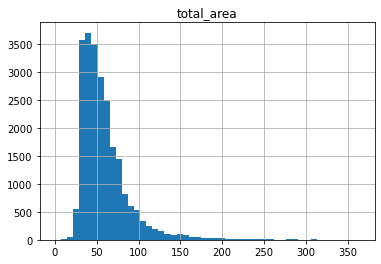

In [440]:
df.hist('total_area', bins=50, grid=True, range=(0, df['total_area'].median()*7))

Цена большинства квартир (75%) укладывается в 6.8 млн рублей

In [441]:
df['last_price'].quantile([0.25, 0.75])

0.25    3400000.0
0.75    6799000.0
Name: last_price, dtype: float64

In [442]:
df['last_price'].describe()

count    2.361100e+04
mean     6.526392e+06
std      1.082262e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

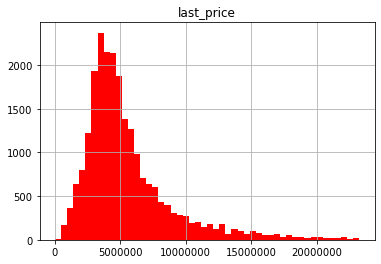

In [443]:
fig, ax = plt.subplots()
df.hist('last_price', bins=50, grid=True, range=(0, df['last_price'].median()*5), color='red', ax=ax)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))

Большая часть потолков не превышает высоту 2.6-2.7 метров

In [444]:
df['ceiling_height'].describe()

count    23611.000000
mean         2.696015
std          0.215586
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020245BE58C8>]],
      dtype=object)

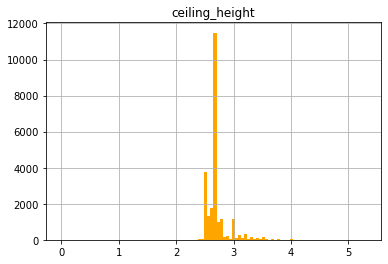

In [445]:
df.hist('ceiling_height', bins=100, grid=True, range=(0, df['ceiling_height'].median()*2), color='orange')

Есть отдельные выбросы до 19 комнат, но типовых 1-, 2- и 3-комнатных квартир большинство

In [446]:
df['rooms'].describe()

count    23611.000000
mean         2.070010
std          1.078206
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020245BFA188>]],
      dtype=object)

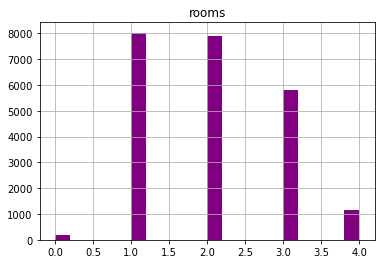

In [447]:
df.hist('rooms', bins=20, grid=True, range=(0, df['rooms'].median()*2), color='purple')

In [448]:
df['rooms'].value_counts(normalize=True)

1     0.339884
2     0.334971
3     0.245267
4     0.049680
5     0.013722
0     0.008259
6     0.004405
7     0.002499
8     0.000508
9     0.000339
10    0.000127
14    0.000085
11    0.000085
19    0.000042
12    0.000042
16    0.000042
15    0.000042
Name: rooms, dtype: float64

### Вывод

У трех из четерёх столбцов большой хвост максимальных значений - комнаты бывает до 19 (основный массив от 1 до 3 комнат), отдельные квартиры стоят до 760 млн рублей (большинство - меньше 10 млн), а площадь отдельных квартир достигает 900 метров (75% - до 70 метров). Только в высоте потолков разброс значений составляет примерно 2 раза - никто не будет строить жильё с потолками в десятки метров

## Исследование количества времени для продажи квартиры

In [449]:
df['days_exposition'].quantile([0.05, 0.95])

0.05      8.0
0.95    668.0
Name: days_exposition, dtype: float64

In [450]:
df['days_exposition'].describe()

count    23611.000000
mean       185.697387
std        233.489646
min          0.000000
25%         43.000000
50%         94.000000
75%        236.500000
max       1618.000000
Name: days_exposition, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000202465AA988>]],
      dtype=object)

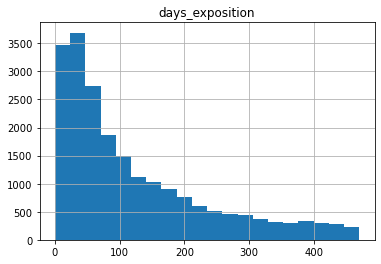

In [451]:
df.hist('days_exposition', bins=20, grid=True, range=(0, df['days_exposition'].median()*5))

### Вывод

График похож на распределение Пуассона - достаточно много быстрых продаж до 100 дней и длинный хвост остальных (до 1618 дней). Стандартное отклонение больше медианы в два с лишним разом - тоже показатель, квартиры могут продаваться очень разное время.

## Анализ редких и выбивающихся значений

In [452]:
columns_with_emissions = ['last_price', 'rooms', 'days_exposition', 'ceiling_height', 'total_area']
 
moustache_dict = dict()
 
for column in columns_with_emissions: 
    quantiles = df[column].quantile([0.25, 0.75])
    iqr = quantiles.iloc[1] - quantiles.iloc[0]
    lowest_point = max(0, quantiles.iloc[0] - 1.5*iqr)
    highest_point = quantiles.iloc[1] + 1.5 * iqr
    moustache_dict[column] = [lowest_point, highest_point]
moustache_dict

{'last_price': [0, 11897500.0],
 'rooms': [0, 6.0],
 'days_exposition': [0, 526.75],
 'ceiling_height': [2.45, 2.8500000000000005],
 'total_area': [0, 114.25]}

In [453]:
df_without_emissions = df[(df.last_price < 11897500.0) & (df.rooms < 6.0)  & (df.days_exposition < 526.75) & 
                          (df.ceiling_height < 2.8500000000000005) & (df.ceiling_height > 2.45) & 
                          (df.total_area < 114.25)]

### Вывод

Выбросов с с учётом отложенного межквартильного интервала оказалось достаточно много: в цене квартир - почти 10% датасета, примерно столько же в сроке продажи. Ещё большое выбросов оказалось в высоте потолков, видимо есть группа зданий с высокими потолками (это могут быть "сталинки"). Меньше всего выбросов в комнатах, меньше 90, видимо это элитное многокомнатное жильё. 

## Исследование факторов, влияющих на стоимость квартиры

In [454]:
df_without_emissions.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_coef,kitchen_coef,price_per_meter,year,month
total_images,1.000000,0.175103,0.111692,0.084224,-0.012422,-0.048149,0.091149,0.033885,-0.029216,-0.024736,...,-0.045574,-0.025301,-0.045574,0.001967,0.002849,0.001575,-0.037474,0.125858,0.145124,0.003480
last_price,0.175103,1.000000,0.677952,0.413059,0.237518,0.007507,0.539593,0.198318,-0.070751,-0.049785,...,-0.478831,-0.228267,-0.478830,-0.247537,0.014739,-0.013536,-0.094915,0.630819,0.031160,0.005727
total_area,0.111692,0.677952,1.000000,0.800896,0.126909,0.001867,0.908799,0.003895,-0.121566,-0.079088,...,-0.077522,-0.026718,-0.077522,-0.056467,0.080605,0.230593,-0.422897,-0.099624,-0.036461,0.011141
rooms,0.084224,0.413059,0.800896,1.000000,-0.105577,-0.013693,0.893985,-0.164135,-0.174093,-0.116994,...,-0.041154,-0.027359,-0.041154,-0.005583,0.065632,0.562931,-0.667101,-0.248575,-0.015858,-0.002971
ceiling_height,-0.012422,0.237518,0.126909,-0.105577,1.000000,0.019290,-0.005870,0.212261,0.047581,0.023653,...,-0.006588,0.027785,-0.006587,-0.040508,0.001406,-0.257250,0.261087,0.191765,-0.106311,0.012757
floors_total,-0.048149,0.007507,0.001867,-0.013693,0.019290,1.000000,-0.009666,0.046990,0.027376,-0.003505,...,-0.016278,-0.016237,-0.016278,-0.031495,0.002569,-0.033013,0.009370,0.012711,-0.023952,-0.000535
living_area,0.091149,0.539593,0.908799,0.893985,-0.005870,-0.009666,1.000000,-0.109889,-0.076270,-0.048248,...,-0.059492,-0.035531,-0.059492,-0.032002,0.073563,0.610648,-0.643094,-0.188707,-0.027486,0.004043
floor,0.033885,0.198318,0.003895,-0.164135,0.212261,0.046990,-0.109889,1.000000,0.042663,0.038217,...,-0.111228,0.054437,-0.111227,-0.035170,-0.031933,-0.275154,0.273935,0.282664,-0.004337,0.021525
studio,-0.029216,-0.070751,-0.121566,-0.174093,0.047581,0.027376,-0.076270,0.042663,1.000000,-0.004955,...,0.027744,0.032676,0.027744,0.003667,-0.023152,0.096399,NaN,0.047495,0.009596,-0.000608
open_plan,-0.024736,-0.049785,-0.079088,-0.116994,0.023653,-0.003505,-0.048248,0.038217,-0.004955,1.000000,...,0.026738,0.019952,0.026738,-0.000046,-0.017494,0.071576,NaN,0.023461,-0.032595,0.029726


Обнаружили значение 0 в 'rooms'. Судя по общему метражу - это студии. Переведём их в разряд однокомнатных квартир.

In [455]:
df_without_emissions.loc[df_without_emissions['rooms'] == 0, 'rooms'] = 1

C:\Users\kryuk\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


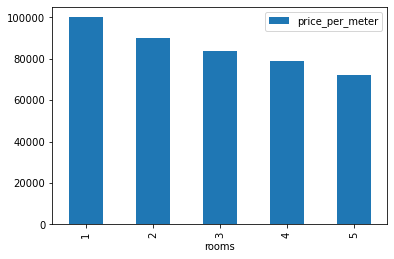

In [456]:
pivot_rooms = df_without_emissions.pivot_table(index='rooms', values='price_per_meter', aggfunc = 'median')
pivot_rooms.plot(kind='bar')

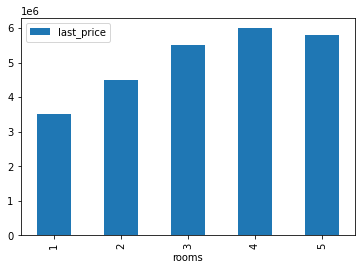

In [457]:
df_without_emissions.pivot_table(index='rooms', values='last_price', aggfunc = 'median').plot(kind='bar')

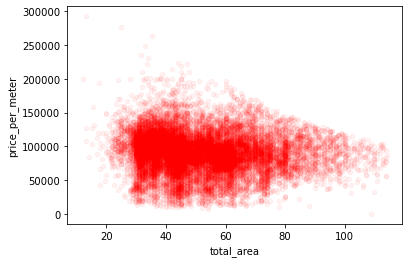

In [458]:
df_without_emissions.plot(x='total_area', y='price_per_meter', kind='scatter', alpha=0.05, color='red')

In [459]:
df_for_corr = df_without_emissions[['price_per_meter', 'last_price', 'rooms', 'cityCenters_nearest', 'total_area']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020245186548>,
      dtype=object)

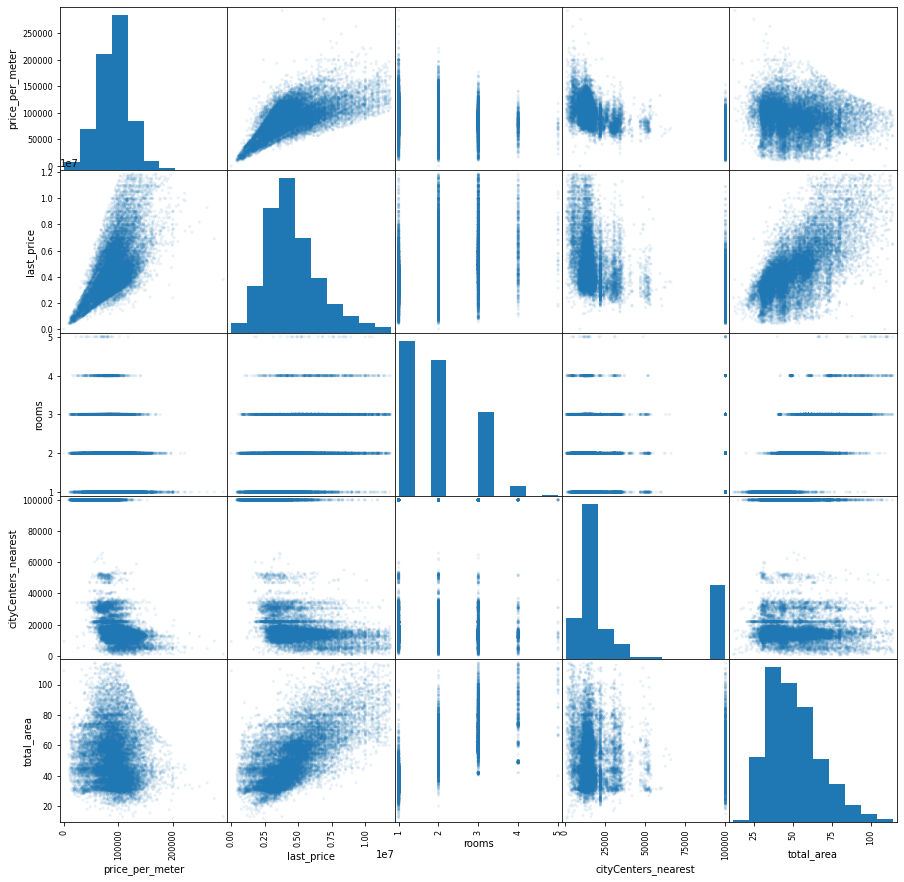

In [460]:
pd.plotting.scatter_matrix(df_for_corr, figsize=(15, 15), alpha=0.1)

Несмотря на то, что маркеры не особо влияют на восприятие значений на графике, на коэффиценте корреляцию они сказываются. Посмотрим его без них.

In [461]:
df_without_marker = df_without_emissions.query('cityCenters_nearest != 99999')
print(df_without_marker['cityCenters_nearest'].corr(df_without_marker['last_price']))
print(df_without_marker['cityCenters_nearest'].corr(df_without_marker['price_per_meter']))

-0.3180943201039841
-0.41329830449375965


In [462]:
df_for_corr.corr()

,price_per_meter,last_price,rooms,cityCenters_nearest,total_area
price_per_meter,1.000000,0.630819,-0.247019,-0.661234,-0.099624
last_price,0.630819,1.000000,0.410821,-0.510019,0.677952
rooms,-0.247019,0.410821,1.000000,-0.006660,0.799027
cityCenters_nearest,-0.661234,-0.510019,-0.006660,1.000000,-0.060719
total_area,-0.099624,0.677952,0.799027,-0.060719,1.000000


In [463]:
df_without_emissions['total_area'].corr(df_without_emissions['price_per_meter'])

-0.09962377128714686

In [464]:
#функция добавляет значениея столбцов
def autolabel(rects, labels=None, height_factor=1.01):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if labels is not None:
            try:
                label = labels[i]
            except (TypeError, KeyError):
                label = ' '
        else:
            label = '%d' % int(height)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                '{}'.format(label),
                ha='center', va='bottom')

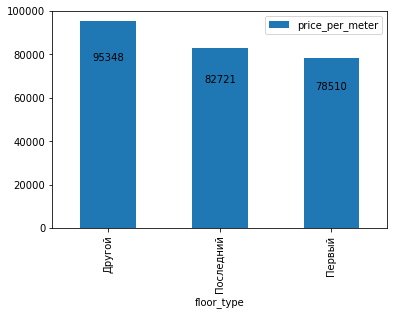

In [465]:
(df_without_emissions.pivot_table(index='floor_type', values='price_per_meter', aggfunc='median')
 .sort_values(by='price_per_meter', ascending = False).plot(kind='bar'))
ax = plt.gca()
autolabel(ax.patches, height_factor=0.8)

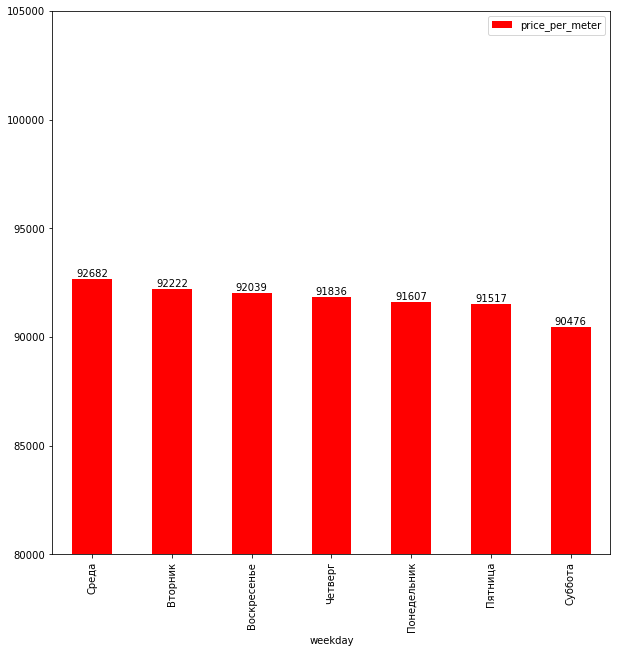

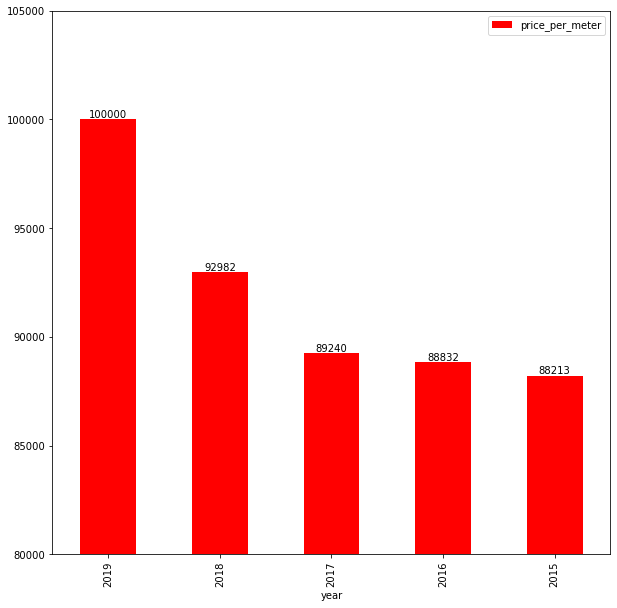

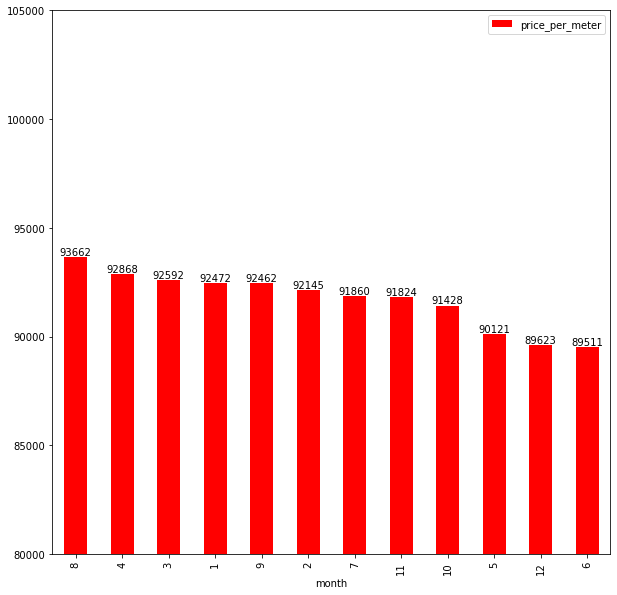

In [466]:
for column in ['weekday', 'year', 'month']:
    (df_without_emissions.pivot_table(index=column, values='price_per_meter', aggfunc='median')
     .sort_values(by='price_per_meter', ascending = False)
     .plot(kind='bar', color='red', ylim=(80000, 105000), figsize=(10,10)))
    ax = plt.gca()
    autolabel(ax.patches, height_factor=1)

## Вывод

Мы рассмотрели зависимость стоимости квадратного метра и общей цены квартиры от нескольких факторов. Относительно количества комнат можнос казать, что мы наблюдаем отрицательную корреляцию в стоимости метра и небольшую положительную в общей цене. Получается, чем меньше комнат, тем квартира дороже в пересчёте на метр - вполне объяснимо, однокомнатыне квартиры всегда пользуются спросом как вариант для покупки первого жилья. В общая стоимость растёт от количества комнта (просто из-за роста площади), но есть интересное проседание в области 5-комнатных квартир. Возможно это бывшие коммунальные квартиры в старых домах с плохими коммуникациями и общим состоянием, из-за чего они могут быть дешевле в цене более современных 4-комнатных, но надо учитывать маленькое количество наблюдений с таким количеством комнта (31 штука) и быть осторожным с выводами.<br>

У расстояние от центра города отрицательная корреляция с ценой - чем дальше, тем дешевле жильё, что предсказуемо.
Общая площадь имеет почти линейную зависимость с общей ценой и корреляцию чуть меньше 0 с стоимостью квадратного метра. С первой всё достаточно очевидно, по второму атрибуту заметно, что жильё премиум класса (150-200 тысяч за метр) достаточно компактное, значений больше 80 метров незаметно.<br>

Стоимость квартир на первом и последнем этажах ниже, чем на остальных, особенно на первом - такие квартиры воспрнимаются как небезопасные и в меньшей степени приватные, а квартиры на последнем этаже чреваты проблемами с возможным протеканием крыши, а также (при отсутствии лифта) трудностями с подниманием на этаж.

Если посмотреть на время размещения объявления, то очевиден рост цен в зависимости от года размещения - если в 2015-2017 цены держались примерно на одном уровне, то к 2019 выросли более чем на 10%, возможно сыграла роль инфляция и изменение курса рубля. Самые низкие медианы по месяцам - в июне и декабре (менее 90 тысяч), самые высокие - в августе (более 93 тысяч), чем это обусловлено сказать сложно. По дням недели самая высокая медиана у среды (более 92 тысяч рублей), самая низкая - у субботы (более 90 тысяч рублей).

## Анализ десяти населённых пунктов с наибольшим числом объявлений

Населённые пункты будем брать из 'toponim' - так данные будут более полными.

In [467]:
top10_towns = df_without_emissions['toponim'].value_counts().sort_values(ascending = False)[:10]

In [468]:
df_without_emissions

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,toponim,living_coef,kitchen_coef,price_per_meter,weekday,year,month,floor_type
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.600000,1,NaN,...,99999,81,Шушары,0.460396,0.272277,82920.792079,Вторник,2018,12,Первый
5,10,2890000.0,30.40,2018-09-10,1,2.65,12,14.400000,5,NaN,...,99999,55,Янино-1,0.473684,0.299342,95065.789474,Понедельник,2018,9,Другой
6,6,3700000.0,37.30,2017-11-02,1,2.65,26,10.600000,6,NaN,...,99999,155,Парголово,0.284182,0.386059,99195.710456,Четверг,2017,11,Другой
7,5,7915000.0,71.60,2019-04-18,2,2.65,24,41.896943,22,NaN,...,99999,15,Санкт-Петербург,NaN,0.263966,110544.692737,Четверг,2019,4,Другой
8,20,2900000.0,33.16,2018-05-23,1,2.65,27,15.430000,26,NaN,...,99999,189,Мурино,0.465320,0.265682,87454.764777,Среда,2018,5,Другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23691,11,9470000.0,72.90,2016-10-13,2,2.75,25,40.300000,7,NaN,...,806,519,Санкт-Петербург,0.552812,0.145405,129903.978052,Четверг,2016,10,Другой
23692,2,1350000.0,30.00,2017-07-07,1,2.65,5,17.500000,4,NaN,...,99999,413,Тихвин,0.583333,0.200000,45000.000000,Пятница,2017,7,Другой
23693,9,4600000.0,62.40,2016-08-05,3,2.60,9,40.000000,8,NaN,...,675,239,Петергоф,0.641026,0.128205,73717.948718,Пятница,2016,8,Другой
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5,38.000000,4,NaN,...,99999,45,Тосно,0.644068,0.144068,52542.372881,Понедельник,2018,1,Другой


In [469]:
df_without_emissions.pivot_table(index='toponim',
                                 values='price_per_meter',
                                 aggfunc=['median', 'count']).sort_values(('count', 'price_per_meter'), 
                                                                          ascending=False)[:10]

,median,count
,price_per_meter,price_per_meter
toponim,,
Санкт-Петербург,101580.135440,11249
Мурино,86270.673555,554
Кудрово,96225.071225,434
Шушары,76584.507042,415
Всеволожск,65454.545455,339
Парголово,91428.571429,311
Колпино,74722.222222,299
Пушкин,97938.144330,267


### Вывод

Самая высокая цена квадратного метра предсказуемо в Петербурге - более 100 тысяч рублей. Далее идут Пушкин (97 тысяч) - здесь удобная логистика, также город богат культурным наследием. Высокая стоимость жилья в Парголово, Кудрово и Мурино - быстрорастущих пригородах Петербурга.

## Анализ изменения цены по степени удалённости от центра

In [470]:
df_without_marker['cityCenters_km'] = df_without_marker['cityCenters_nearest'] / 1000

C:\Users\kryuk\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [471]:
df_without_marker['cityCenters_km'] = df_without_marker['cityCenters_km'].round()

C:\Users\kryuk\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


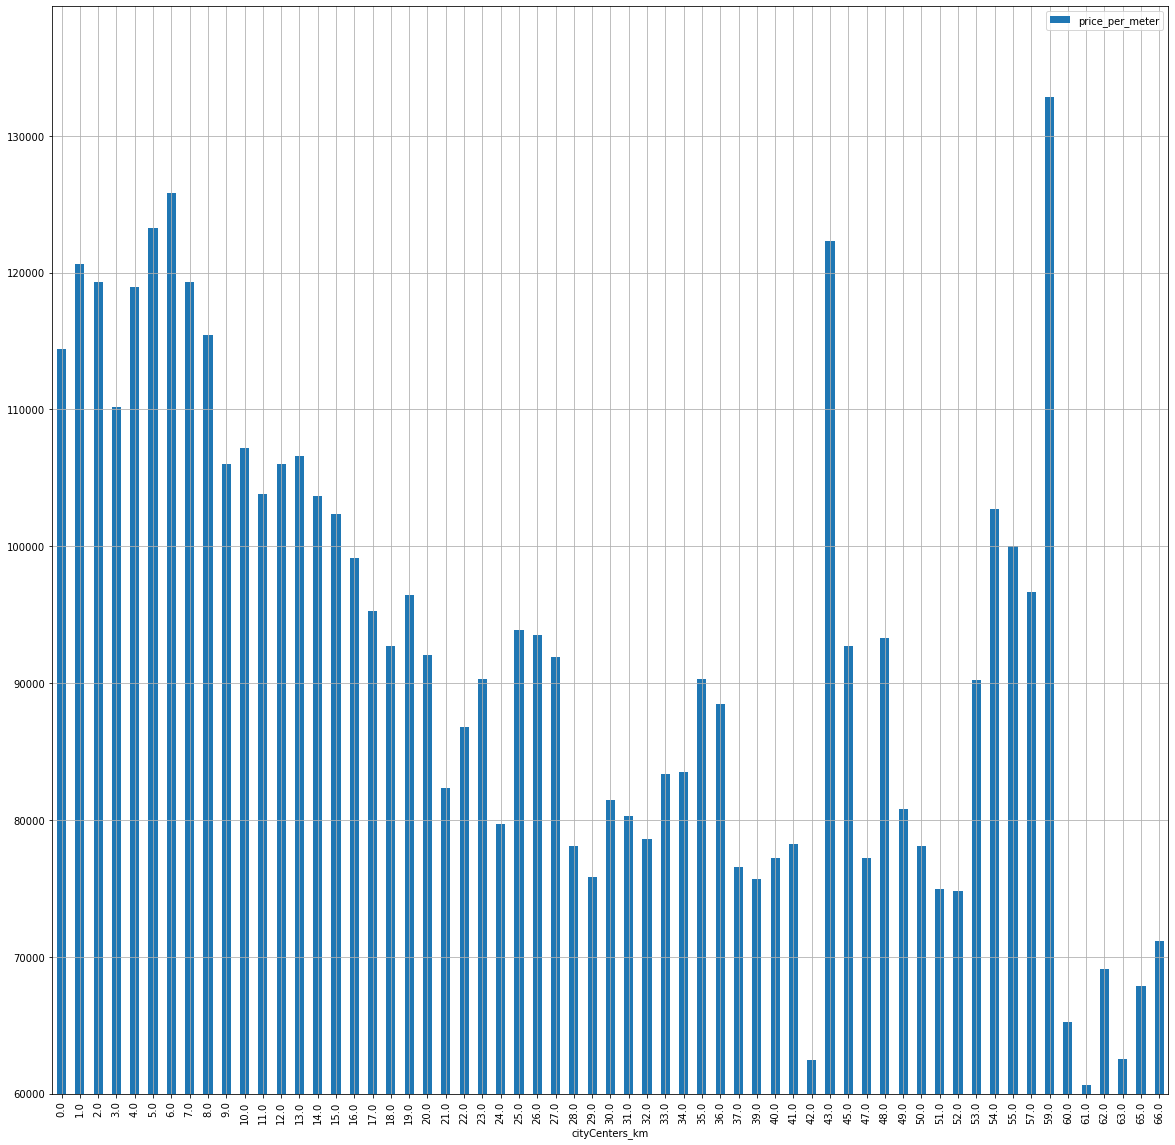

In [472]:
(df_without_marker.pivot_table(index='cityCenters_km', values='price_per_meter', aggfunc='mean')
 .sort_values('cityCenters_km').plot(kind='bar', figsize=(20, 20), ylim=(60000), grid=True))

In [473]:
df1 = df.query('cityCenters_nearest != 99999')

In [474]:
df_without_emissions['cityCenters_km'] = df_without_marker['cityCenters_nearest'] / 1000
df_without_emissions['cityCenters_km'] = df_without_marker['cityCenters_km'].round()

C:\Users\kryuk\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\kryuk\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Заметно, что есть высокие значения сильно загородом - возможно, это коттеджи, посмотрим их количество, возможно их можно убрать.

In [475]:
df_without_marker['cityCenters_km'].value_counts()

12.0    1419
15.0    1351
13.0    1262
16.0    1134
14.0    1124
        ... 
65.0       1
66.0       1
61.0       1
55.0       1
62.0       1
Name: cityCenters_km, Length: 61, dtype: int64

In [476]:
for value in df_without_marker['cityCenters_km'].value_counts():
    print(value)

1419
1351
1262
1134
1124
934
782
749
547
385
341
334
314
267
263
262
209
197
182
177
130
116
114
112
111
108
104
104
104
80
74
69
69
66
49
45
42
34
32
26
21
19
13
12
10
8
6
3
3
3
2
2
1
1
1
1
1
1
1
1
1


In [477]:
#отфильтруем те значение, которые содержат меньше 5 объявлений
df_without_marker = df_without_marker[df_without_marker['cityCenters_km']
                                      .map(df_without_marker['cityCenters_km'].value_counts()) > 5]

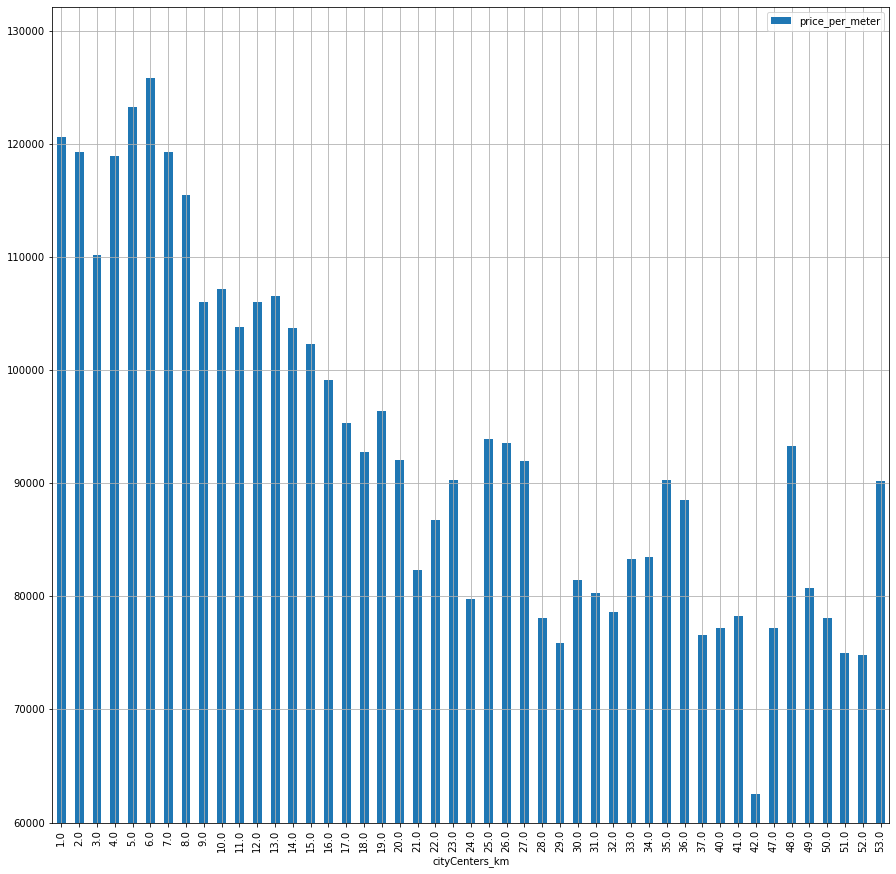

In [478]:
df_without_marker.pivot_table(index='cityCenters_km', values='price_per_meter', aggfunc='mean').sort_values('cityCenters_km').plot(kind='bar', figsize=(15, 15), ylim=(60000), grid=True)

### Вывод

Как можно заметить по графику, средняя цена за квадратный метр начинает стабильно снижаться с 9 км, так что обозначим за радиус центра 8 км

## Сравнение выводов по квартирам в центре и общих выводов по всему городу

In [479]:
df_center = df_without_marker.query('cityCenters_km <= 8.0')

In [480]:
len(df_center)

1470

По сравнению с общей базой квартир, квартиры в центре в среднем имеют большую площадь

In [481]:
df_center['total_area'].describe()

count    1470.000000
mean       59.109599
std        20.070794
min        12.000000
25%        43.525000
50%        57.000000
75%        72.000000
max       114.200000
Name: total_area, dtype: float64

In [482]:
df_without_marker['total_area'].describe()

count    13911.000000
mean        51.522039
std         17.110034
min         12.000000
25%         38.200000
50%         47.100000
75%         62.000000
max        114.200000
Name: total_area, dtype: float64

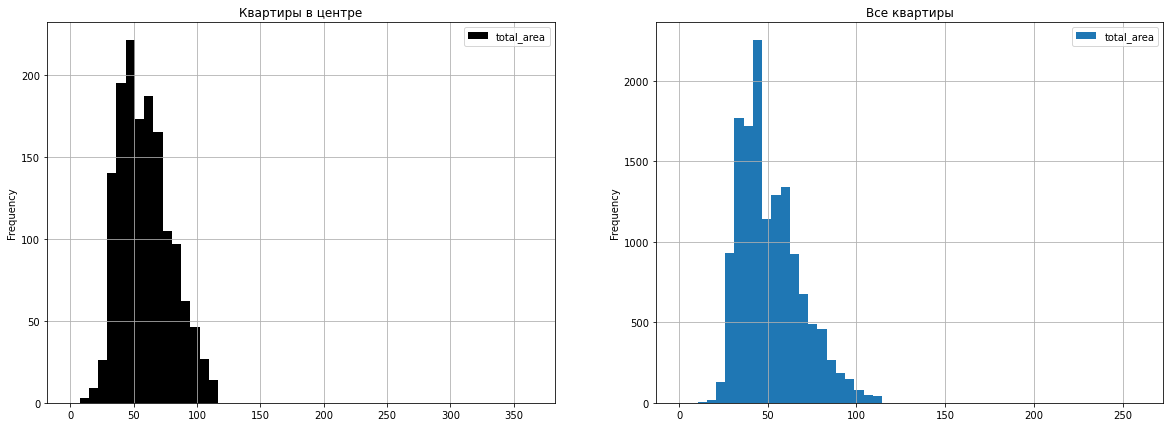

In [483]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df_center['total_area'].plot(kind='hist', bins=50, grid=True, range=(0, df['total_area'].median()*7), color='black', 
                             ax=axes[0], figsize=(6, 20), title='Квартиры в центре', legend='total_area')
df_without_marker['total_area'].plot(kind='hist', bins=50, grid=True, range=(0, df['total_area'].median()*5), 
                                     ax=axes[1], figsize=(20, 7), title='Все квартиры', legend='total_area')

In [484]:
df_center['last_price'].describe()

count    1.470000e+03
mean     6.853186e+06
std      2.231774e+06
min      1.686000e+06
25%      5.100000e+06
50%      6.700000e+06
75%      8.500000e+06
max      1.187925e+07
Name: last_price, dtype: float64

In [485]:
df_without_marker['last_price'].describe()

count    1.391100e+04
mean     5.120506e+06
std      1.912598e+06
min      1.219000e+04
25%      3.725000e+06
50%      4.650000e+06
75%      6.050000e+06
max      1.188000e+07
Name: last_price, dtype: float64

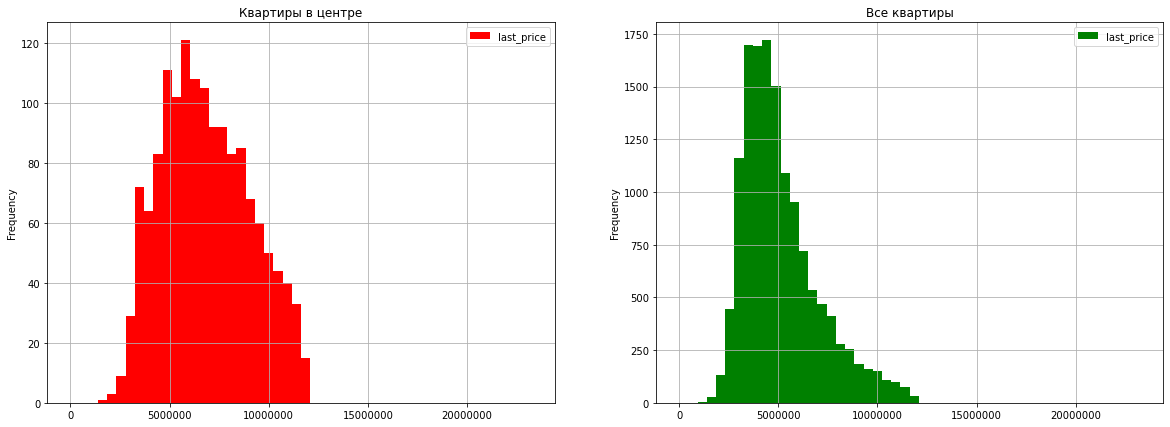

In [486]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df_center['last_price'].plot(kind='hist', bins=50, grid=True, range=(0, df['last_price'].median()*5), color='red', 
                             ax=axes[0], figsize=(6, 20), title='Квартиры в центре', legend='last_price')
axes[0].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
df_without_marker['last_price'].plot(kind='hist', bins=50, grid=True, range=(0, df['last_price'].median()*5), 
                                     color='green', ax=axes[1], figsize=(20, 7), title='Все квартиры', legend='last_price')
axes[1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))

In [487]:
df_without_marker['price_per_meter'].describe()

count     13911.000000
mean     100722.971971
std       22800.437499
min         111.834862
25%       85182.712753
50%       98275.862069
75%      113095.238095
max      292307.692308
Name: price_per_meter, dtype: float64

In [488]:
df_center['price_per_meter'].describe()

count      1470.000000
mean     119699.162464
std       29266.521104
min       26250.000000
25%       99158.755274
50%      115493.295019
75%      136980.769231
max      292307.692308
Name: price_per_meter, dtype: float64

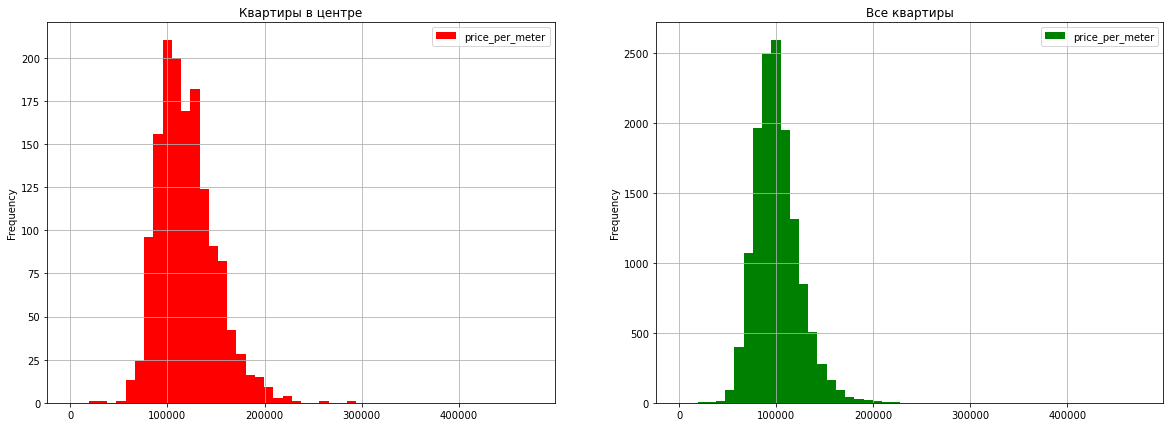

In [489]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df_center['price_per_meter'].plot(kind='hist', bins=50, grid=True, range=(0, df['price_per_meter'].median()*5), color='red', 
                             ax=axes[0], figsize=(6, 20), title='Квартиры в центре', legend='price_per_meter')
df_without_marker['price_per_meter'].plot(kind='hist', bins=50, grid=True, range=(0, df['price_per_meter'].median()*5), 
                                     color='green', ax=axes[1], figsize=(20, 7), title='Все квартиры', legend='price_per_meter')

Как по общей стоимости, так и по цене квадрата, квартиры в центре дороже других квартир.

In [490]:
df_without_marker['rooms'].describe()

count    13911.000000
mean         1.872547
std          0.861636
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: rooms, dtype: float64

In [491]:
df_center['rooms'].describe()

count    1470.000000
mean        2.066667
std         0.880724
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: rooms, dtype: float64

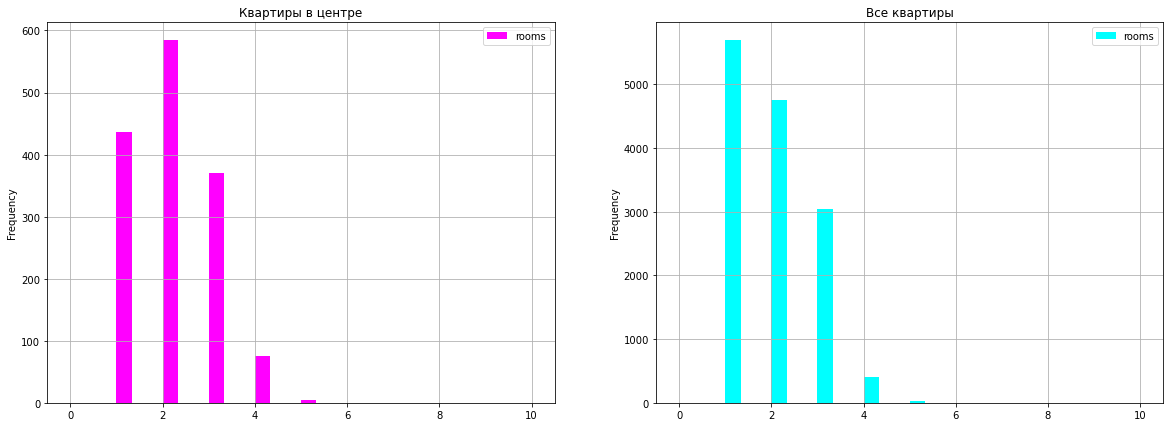

In [492]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df_center['rooms'].plot(kind='hist', bins=30, grid=True, range=(0, df['rooms'].median()*5), color='magenta', 
                             ax=axes[0], figsize=(6, 20), title='Квартиры в центре', legend='rooms')
df_without_marker['rooms'].plot(kind='hist', bins=30, grid=True, range=(0, df['rooms'].median()*5), 
                                     color='cyan', ax=axes[1], figsize=(20, 7), title='Все квартиры', legend='rooms')

Среди квартир в центре больше однокомнатных, чем двухкомнтаных, в остальном датасете наоборот

In [493]:
df_center['ceiling_height'].describe()

count    1470.000000
mean        2.654864
std         0.076692
min         2.460000
25%         2.650000
50%         2.650000
75%         2.650000
max         2.850000
Name: ceiling_height, dtype: float64

In [494]:
df_without_marker['ceiling_height'].describe()

count    13911.000000
mean         2.629738
std          0.081376
min          2.460000
25%          2.570000
50%          2.650000
75%          2.650000
max          2.850000
Name: ceiling_height, dtype: float64

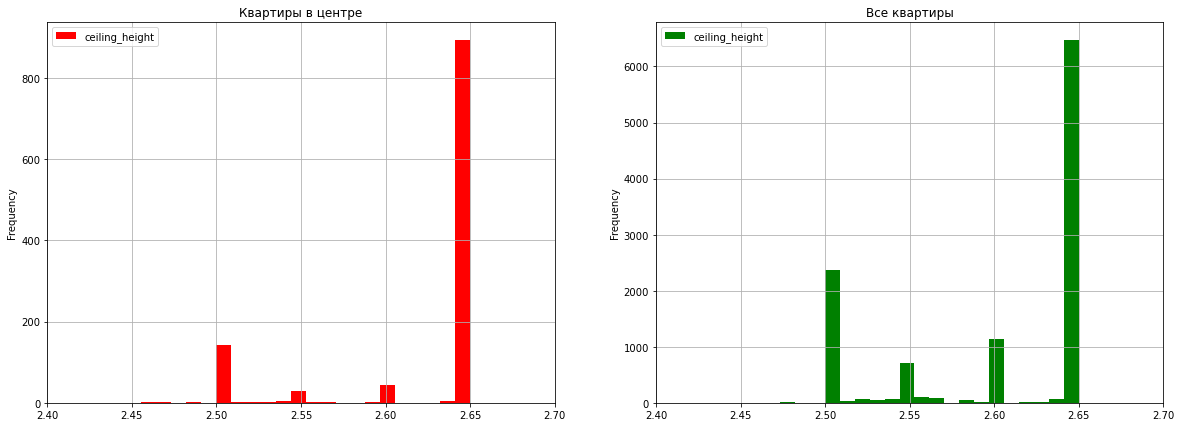

In [495]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df_center['ceiling_height'].plot(kind='hist', bins=300, grid=True, range=(0, df['ceiling_height'].median()), color='red', 
                             ax=axes[0], figsize=(6, 20), title='Квартиры в центре', legend='ceiling_height', xlim=(2.4, 2.7))
df_without_marker['ceiling_height'].plot(kind='hist', bins=300, grid=True, range=(0, df['ceiling_height'].median()), 
                                     color='green', ax=axes[1], figsize=(20, 7), title='Все квартиры', legend='ceiling_height', xlim=(2.4, 2.7))

По высоте потолков выборка от датасета почти не отличается

In [496]:
def plotbar_by_median(index, color, title):
    (df_center.pivot_table(index=index, values='price_per_meter', aggfunc='median').
     plot(kind='bar', color=color, grid=True, title=title))

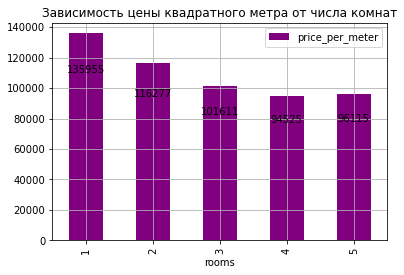

In [497]:
plotbar_by_median('rooms', 'purple', 'Зависимость цены квадратного метра от числа комнат')
ax = plt.gca()
autolabel(ax.patches, height_factor=0.8)

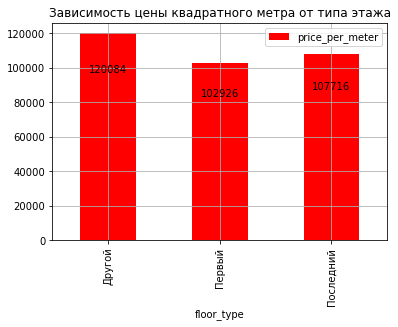

In [498]:
plotbar_by_median('floor_type', 'red', 'Зависимость цены квадратного метра от типа этажа')
ax = plt.gca()
autolabel(ax.patches, height_factor=0.8)

In [499]:
df_center.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'toponim', 'living_coef',
       'kitchen_coef', 'price_per_meter', 'weekday', 'year', 'month',
       'floor_type', 'cityCenters_km'],
      dtype='object')

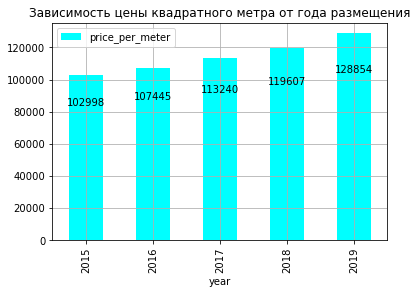

In [500]:
plotbar_by_median('year', 'cyan', 'Зависимость цены квадратного метра от года размещения')
ax = plt.gca()
autolabel(ax.patches, height_factor=0.8)

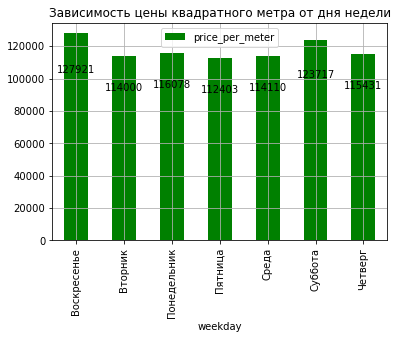

In [501]:
plotbar_by_median('weekday', 'green', 'Зависимость цены квадратного метра от дня недели')
ax = plt.gca()
autolabel(ax.patches, height_factor=0.8)

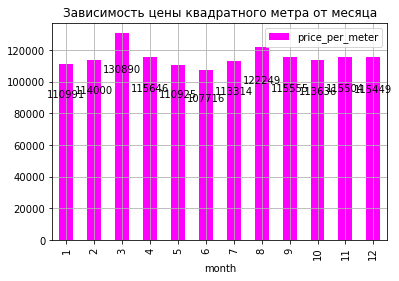

In [502]:
plotbar_by_median('month', 'magenta', 'Зависимость цены квадратного метра от месяца')
ax = plt.gca()
autolabel(ax.patches, height_factor=0.8)

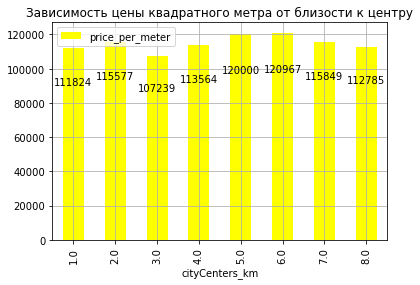

In [503]:
plotbar_by_median('cityCenters_km', 'yellow', 'Зависимость цены квадратного метра от близости к центру')
ax = plt.gca()
autolabel(ax.patches, height_factor=0.8)

### Вывод

По проанализированным показателям выходит, что более близкое к центру жильё оказывается более просторным и оттого более дорогим - у него больший метраж, больше комнат, примерно на 20% больше стоимость, чем у остальных квартир.<br>
Относительно факторов, влияющих на стоимость - корреляция в целом та же, что и у других квартир, чем меньше комнат, тем дороже квадратный метр; схожая картина по количеству этажей. Возрастание цены метра от года размещения более плавное в сравнении с другими квартирами, и сходно с величиной инфляиции - кажется, цена квартир в центре более стабильная.<br>
От основного датасета отличается зависимость от дня недели размещения. Здесь несколько выше цена метра у объявлений, размещенных в выходные (в основном это была среда), но объяснить эту зависимость сложно. По месяцам же картина схожая. <br>
Расстояние от центра также с трудом поддаётся трактовке - у более отдалённых от центра (например, на 5-6 км) цена оказывается выше, чем у более "центральных" квартир.

### Общий вывод

Данные оказались не самыми полными, нам пришлось изменять многие типы данных с вещественных на натуральные, преобразовывать в формат даты. Были сложности и с пропусками - в 'days_exposition' было много пропусков в объявленниях, похожих на неснятые объявления. Было сложно решить, как их заполнять: разницей с сегодняшней датой, с датой самого нового размещения, медианой или вообще убрать? Некоторые столбцы удавалось заполнить медианами по группировке других столбцов, но иногда и после этого остались пропуски уже из-за пропусков в первых столбцах. Обнаружилось, что часть населенных пунктов были дублированы из-за разных типов населенных пунктов у одного и того же топонима - эту проблему удалось решить с помощью регулярных выражений.<br>
При обработке выбросов оказалось, что у нужных колонок имеется длинный хвост высоких значений - даже с откалдыванием межквартильного размаха их оказывалось до несколько тысяч, но несмотря на это, их всё равно нужно фильтровать.<br>

Мы рассмотрели зависимость стоимости квадратного метра и общей цены квартиры от нескольких факторов. Здесь мы наблюдаем отрицательную корреляцию в стоимости метра и небольшую положительную в общей цене. Получается, чем меньше комнат, тем квартира дороже в пересчёте на метр - вполне объяснимо, однокомнатные квартиры всегда пользуются спросом как вариант для покупки первого жилья.<br>

У расстояние от центра города отрицательная корреляция с ценой - чем дальше, тем дешевле жильё, что предсказуемо. Общая площадь имеет почти линейную зависимость с общей ценой и корреляцию чуть меньше 0 с стоимостью квадратного метра. С первой всё достаточно очевидно, по второму атрибуту заметно, что жильё премиум класса (150-200 тысяч за метр) достаточно компактное, значений больше 80 метров незаметно.<br>

Стоимость квартир на первом и последнем этажах ниже, чем на остальных, особенно на первом - такие квартиры воспрнимаются как небезопасные и в меньшей степени приватные, а квартиры на последнем этаже чреваты проблемами с возможным протеканием крыши, а также (при отсутствии лифта) трудностями с подниманием на этаж.<br>

Если посмотреть на время размещения объявления, то очевиден рост цен в зависимости от года размещения - если в 2015-2017 цены держались примерно на одном уровне, то к 2019 выросли более чем на 10%, возможно сыграла роль инфляция и изменение курса рубля. При этом у центральных квартир стоимость росла более плавно, по несколько процентов в год. <br>

Самая высокая цена квадратного метра предсказуемо в Петербурге - более 100 тысяч рублей. Далее идёт Пушкин (97 тысяч) - крупный город с хорошей туристической составляющей и близкий к Петербургу. Высокая стоимость жилья в Парголово, Кудрово и Мурино - быстрорастущих спальных пригородах Петербурга.<br>

По квартирам в центре заметно, что они более просторные и оттого более дорогие - у них больший метраж, больше комнат, примерно на 20% больше стоимость, чем у остальных квартир.